In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as st
from scipy.optimize import least_squares
import pickle
import arviz as az
import scipy as sp
import aesara.tensor as at

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(f"Running on PyMC3 v{pm.__version__}")

# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

Running on PyMC3 v3.11.4


In [12]:
# True parameter values
a_true = 20
theta_true = 0.65

sigma_true = 0.01

# Size of dataset
size = 250

# Predictor variable
X = np.linspace(0.2,4,num = size)

# simulated observations
epsilon = np.random.randn(size) * sigma_true
Y_true = (theta_true*X)/(1 + (X/a_true))
observations = Y_true + epsilon

# simulated observations
def simulator(theta, x):
    return theta*x

In [ ]:
# # 
# basic_model = pm.Model()
# with basic_model:
#     # Priors for unknown model parameters
#     theta = pm.Normal('theta',mu = 0.5, sigma = 1)

#     # Expected value of outcome
#     mu = simulator(theta, X)

#     # Likelihood (sampling distribution) of observations
#     Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma_true, observed=Y_obs)
#     trace = pm.sample(2000, tune = 1000, chains = 2, return_inferencedata=False, cores=1)

#     print(az.summary(trace, round_to=2))
#     az.plot_trace(trace)
#     plt.show()

done


C:\Users\Rahul\AppData\Local\Temp\ipykernel_1648\898243708.py:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune = 1000, chains = 2, cores=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eta, length_scale, theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 368 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8832488533056734, but should be close to 0.8. Try to increase the number of tuning steps.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


              mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta         0.65  0.96   -1.20     2.30       0.03     0.02   1365.22   
length_scale  2.77  0.54    1.84     3.81       0.02     0.01    892.15   
eta           1.70  0.68    0.75     2.90       0.02     0.01   1186.02   

              ess_tail  r_hat  
theta          1347.04    1.0  
length_scale    643.25    1.0  
eta            1427.55    1.0  


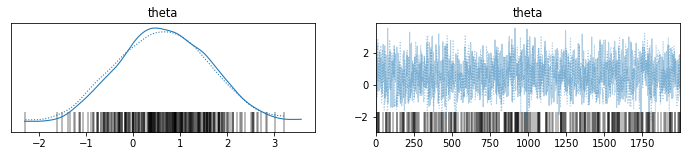

In [8]:
# solve with bayesian inference, model discrepancy included
X = X.reshape((-1,1))

discrepancy_gp_model = pm.Model()
class Blackbox_Model(pm.gp.mean.Mean):
    def __init__(self, Theta):
        self.theta = Theta

    def __call__(self, x):
        # return simulator prediction given theta and X
        return simulator(self.theta, x)

print('done')

with discrepancy_gp_model:
    # priors on parameters
    # half-normal distribution may be biasing it to be larger
    theta = pm.Normal('theta',mu = 0.5, sigma = 1)

    # priors for GP covariance
    length_scale = pm.Bound(pm.Gamma, upper = 4)("length_scale", alpha=5, beta=5) # taken from discrepancy modeling paper
    # length_scale = pm.Gamma("length_scale", alpha=2, beta=1) # taken from discrepancy modeling paper
    eta = pm.HalfCauchy('eta', beta=5)

    # prior on discrepancy function (zero mean)
    mean_func = Blackbox_Model(theta)
    cov_func = (eta**2) * pm.gp.cov.ExpQuad(1, ls=length_scale)
    gp = pm.gp.Marginal(mean_func= mean_func, cov_func = cov_func)

    # discrepancy = gp.prior("discrepancy", X = X)
    y_ = gp.marginal_likelihood("y", X=X, y=observations, noise = sigma_true)

    # run inference
    trace = pm.sample(2000, tune = 1000, chains = 2, cores=1)
    az.plot_trace(trace, var_names=["theta"]);
    print(az.summary(trace, round_to=2))

    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, eta, length_scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 332 seconds.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


              mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta         0.67  1.01   -1.13     2.69       0.03     0.02   1285.32   
length_scale  2.87  0.53    1.91     3.83       0.02     0.01    935.33   
eta           1.69  0.71    0.79     2.86       0.02     0.02    970.76   

              ess_tail  r_hat  
theta          1817.22    1.0  
length_scale    655.57    1.0  
eta             569.72    1.0  


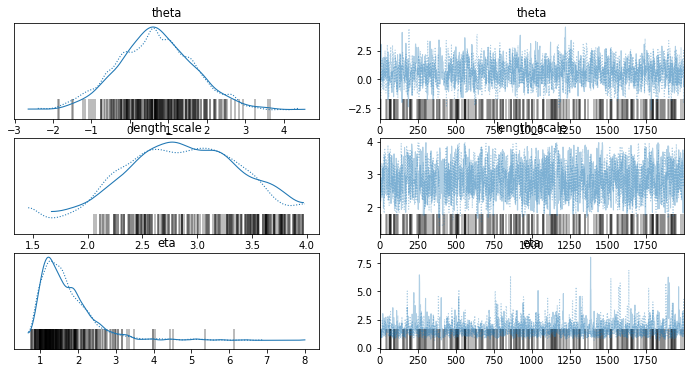

In [13]:
#-----------------------------------------solve with bayesian inference with model discrepancy (formulation 2)-----------------
X = X.reshape((-1,1))

basic_model = pm.Model()
with basic_model:
    
    length_scale = pm.Bound(pm.Gamma, upper = 4)("length_scale", alpha=5, beta=5) # taken from discrepancy modeling paper
    # length_scale = pm.Gamma("length_scale", alpha=2, beta=1) # taken from discrepancy modeling paper
    eta = pm.HalfCauchy('eta', beta=5)
    
    cov_func = (eta**2) * pm.gp.cov.ExpQuad(1, ls=length_scale) 
    Sigma = cov_func(X) + np.eye(size)*sigma_true**2
    
    # Priors for unknown model parameters
    theta = pm.Normal('theta',mu = 0.5, sigma = 1)

    # Expected value of outcome
    mu = simulator(theta, X)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.MvNormal("Y_obs", mu=mu, cov=Sigma, observed=observations)
    
    trace = pm.sample(2000, tune = 1000, chains = 2, return_inferencedata=False, cores=1)

    print(az.summary(trace, round_to=2))
    az.plot_trace(trace)
    plt.show()

In [10]:
# solve with Bayesian Inference, no discrepancy 
np.eye(size)*sigma_true


array([[0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01]])